In [1]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense, Activation, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Reshape, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
train_path = '/kaggle/input/garbage-classification-v2/Garbage Classification'

def load_dataset(path, target_shape):
    class_folders = os.listdir(path)
    filenames = []
    labels = []

    for i, class_folder in enumerate(class_folders):
        folder_path = os.path.join(path, class_folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            try:
                image = cv2.imread(image_path)
                if image is None:
                    continue  # Skip non-image files
                resized_image = cv2.resize(image, target_shape[:2])
                filenames.append(resized_image)
                labels.append(i)
            except Exception as e:
                print(f"Error processing image: {image_path} - {e}")

    X = np.array(filenames)
    y = np.array(labels)

    # Normalize pixel values
    X = X.astype('float32') / 255.0

    # Convert labels to categorical
    y = np_utils.to_categorical(y)

    return X, y


# Define the target shape for resizing images
target_shape = (110, 110, 3)

# Load and preprocess the dataset
X, y = load_dataset(train_path, target_shape)

# Split the dataset into training, testing, and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("Shape of X_train, y_train:", X_train.shape, y_train.shape)
print("Shape of X_test, y_test:", X_test.shape, y_test.shape)
print("Shape of X_val, y_val:", X_val.shape, y_val.shape)

    

libpng warning: sRGB: out of place
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: sRGB: out of place
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: sRGB: out of place
libpng warning: sRGB: out of place


Shape of X_train, y_train: (15827, 110, 110, 3) (15827, 10)
Shape of X_test, y_test: (4397, 110, 110, 3) (4397, 10)
Shape of X_val, y_val: (1759, 110, 110, 3) (1759, 10)


In [3]:
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = GlobalAveragePooling2D()(input)
    se = Dense(filters // se_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [4]:
import tensorflow as tf
from keras.layers import Input, Dense,UpSampling2D, Activation, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Flatten, concatenate

from keras.layers import concatenate, multiply
from keras.models import Model

from tensorflow.keras.applications.densenet import DenseNet201
# Define the model architecture with parallel CNNs
def create_parallel_cnn_model(input_shape, num_classes):
    MainInput = Input(shape=input_shape)
    dn169 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')(MainInput)
    reshape = Reshape((8, 8, 26))(dn169)

    # First branch
    conv1 = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    image_size_2 = 8
    conv1 = Reshape(target_shape=(image_size_2, image_size_2, 128))(conv1)
    x1 = squeeze_excite_block(conv1, 128, 128)
    conv1 = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(strides=(2, 2), padding="same")(conv1)
    conv1 = Conv2D(filters=256, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=256, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=256, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    image_size_3 = 4
    conv1 = Reshape(target_shape=(image_size_3, image_size_3, 256))(conv1)
    x1 = squeeze_excite_block(conv1, 256, 256)
    conv1 = Conv2D(filters=256, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=256, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(filters=256, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv1)
    conv1 = Flatten()(conv1)

    # Second branch
    conv2 = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    image_size_2 = 8
    conv2 = Reshape(target_shape=(image_size_2, image_size_2, 128))(conv2)
    x2 = squeeze_excite_block(conv2, 128, 128)
    conv2 = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D(strides=(2, 2), padding="same")(conv2)
    conv2 = Conv2D(filters=256, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=256, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=256, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    image_size_3 = 4
    conv2 = Reshape(target_shape=(image_size_3, image_size_3, 256))(conv2)
    x2 = squeeze_excite_block(conv2, 256, 256)
    conv2 = Conv2D(filters=256, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=256, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(filters=256, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv2)
    conv2 = Flatten()(conv2)

    # Concatenate both branches
    merged = concatenate([conv1, conv2])

    # Dense layers
    dense1 = Dense(1024, activation="relu")(merged)
    dense2 = Dense(512, activation="relu")(dense1)
    output = Dense(num_classes, activation="softmax")(dense2)

    # Create the model
    model = Model(inputs=MainInput, outputs=output)

    return model


# Create the model
num_classes = y_train.shape[1]
model = create_parallel_cnn_model(target_shape, num_classes)
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, epsilon=0.1), metrics=['accuracy'])



51877672/51877672 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 110, 110, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet169 (Functional)       (None, 1664)         12642880    ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 8, 8, 26)     0           ['densenet169[0][0]']            
                                                                                                  
 conv2d (Conv2D)             

In [5]:


# Set up a checkpoint to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25, min_delta=0.001)

# Record the start time
import time
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train,
                          epochs=35,
                          batch_size=10,
                          validation_data=(X_val, y_val),
                          callbacks=[checkpoint, early_stopping])

# Calculate the total training time
end_time = time.time()
total_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(total_time))

Epoch 1/35
1583/1583 [==============================] - 175s 91ms/step - loss: 1.5896 - accuracy: 0.4733 - val_loss: 9.6712 - val_accuracy: 0.7226
Epoch 2/35
1583/1583 [==============================] - 134s 85ms/step - loss: 0.8199 - accuracy: 0.7363 - val_loss: 0.7348 - val_accuracy: 0.7953
Epoch 3/35
1583/1583 [==============================] - 140s 88ms/step - loss: 0.5475 - accuracy: 0.8293 - val_loss: 0.4000 - val_accuracy: 0.8727
Epoch 4/35
1583/1583 [==============================] - 134s 85ms/step - loss: 0.3961 - accuracy: 0.8764 - val_loss: 0.3834 - val_accuracy: 0.8994
Epoch 5/35
1583/1583 [==============================] - 137s 87ms/step - loss: 0.3091 - accuracy: 0.9070 - val_loss: 0.3559 - val_accuracy: 0.8960
Epoch 6/35
1583/1583 [==============================] - 132s 83ms/step - loss: 0.2391 - accuracy: 0.9267 - val_loss: 0.3147 - val_accuracy: 0.9159
Epoch 7/35
1583/1583 [==============================] - 138s 87ms/step - loss: 0.1970 - accuracy: 0.9392 - val_loss: 0

Number of epochs trained: 35


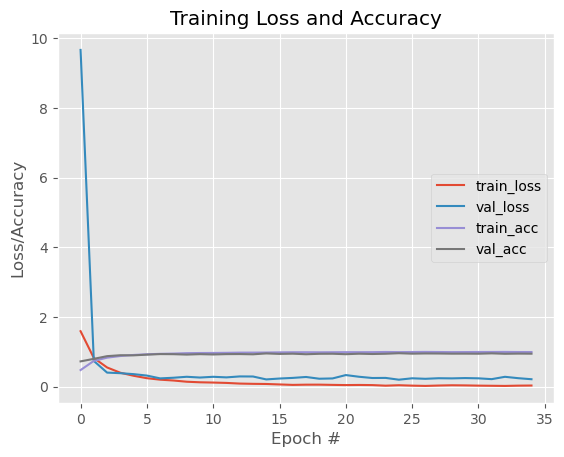

In [6]:
# Load the best weights
model.load_weights('/kaggle/working/model.h5')

# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("parallelCNN_Model")

# Determine number of epochs trained
num_epochs_trained = len(history.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

In [7]:
# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

Test loss: 0.17233914136886597
Test accuracy: 0.955651581287384


In [8]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

report = classification_report(y_test_labels, y_pred)
print(report)

138/138 [==============================] - 9s 38ms/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       346
           1       0.94      0.98      0.96       792
           2       0.98      0.96      0.97       235
           3       0.93      0.95      0.94       421
           4       0.96      0.97      0.96       185
           5       0.95      0.92      0.94       132
           6       0.95      0.94      0.94       389
           7       0.95      0.95      0.95       387
           8       0.99      0.98      0.99      1065
           9       0.96      0.91      0.93       445

    accuracy                           0.96      4397
   macro avg       0.95      0.95      0.95      4397
weighted avg       0.96      0.96      0.96      4397



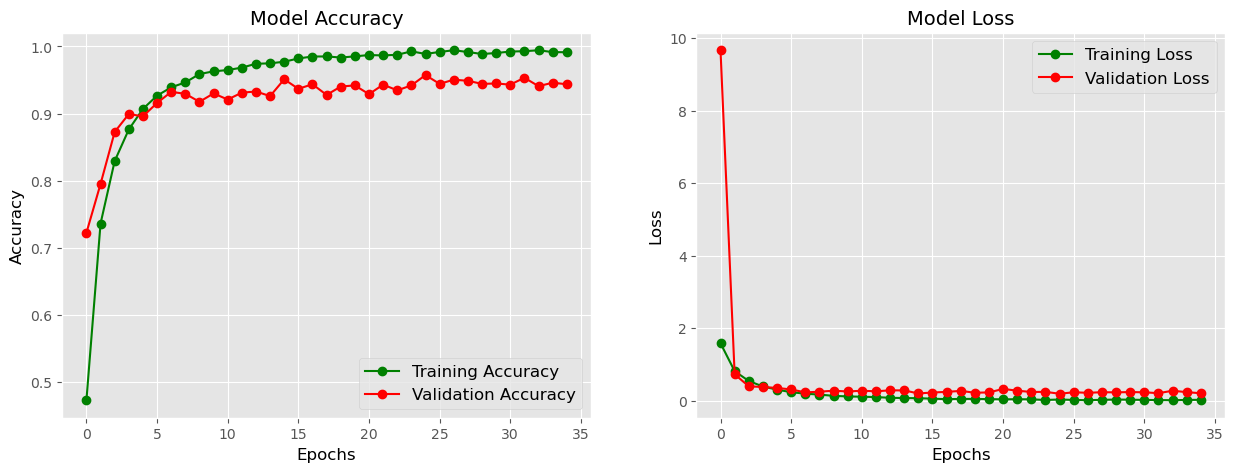

In [9]:
# History plotting
epochs = [i for i in range(num_epochs_trained)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15, 5)

# Plotting accuracy
ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
title_font = {'fontname': 'Times New Roman', 'size': '14', 'color': 'black', 'weight': 'normal'}
ax[0].set_title('Model Accuracy', fontdict=title_font)
legend_font = {'family': 'Times New Roman', 'size': '12', 'weight': 'normal'}
ax[0].legend(prop=legend_font)
label_font = {'fontname': 'Times New Roman', 'size': '12', 'color': 'black', 'weight': 'normal'}
ax[0].set_xlabel("Epochs", fontdict=label_font)
ax[0].set_ylabel("Accuracy", fontdict=label_font)

# Plotting loss
ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Model Loss', fontdict=title_font)
ax[1].legend(prop=legend_font)
ax[1].set_xlabel("Epochs", fontdict=label_font)
ax[1].set_ylabel("Loss", fontdict=label_font)

plt.show()

138/138 [==============================] - 5s 38ms/step


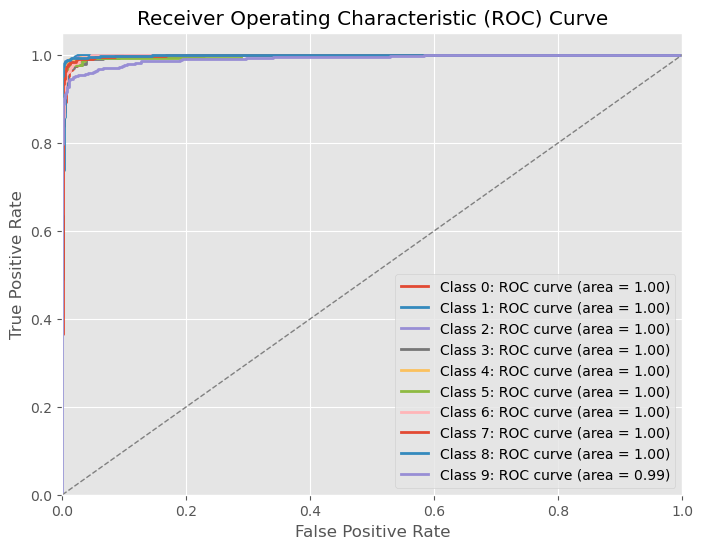

In [10]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for each class
y_pred_probs = model.predict(X_test)

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(y_test.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='Class {}: ROC curve (area = {:.2f})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
